# XGBoost Notebook

This Notebook trains an XGBoost model, predicts the player's points for the upcoming gameweeks, and saves these predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tabulate import tabulate
import requests
import pickle

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import pulp

### Load data

In [2]:
# Load the saved JSON data from the file
with open("data/overall_data.json", "r") as f:
    data = json.load(f)
players = data['elements']

# Create player_overall_stats
player_overall_stats = {}
for player in players:
    player_id = str(player['id'])
    player_overall_stats[player_id] = player

In [3]:
# Load training data
X = np.load('data/xgboost/X_train.npy')
y = np.load('data/xgboost/y_train.npy')
played = np.load('data/xgboost/played_train.npy') # Optional: Used to remove data where a player did not play

print("Training data (X):", X.shape)
print("Target values (y):", y.shape)
print("Played values (y):", played.shape)

Training data (X): (81136, 195)
Target values (y): (81136,)
Played values (y): (81136,)


In [4]:
# Load test data
with open('data/xgboost/X_test.pkl', 'rb') as f:
    X_test_games = pickle.load(f)

with open('data/xgboost/xP_test.pkl', 'rb') as f:
    eP_games = pickle.load(f)

with open('data/xgboost/names_test.pkl', 'rb') as f:
    player_names_games = pickle.load(f)
    
with open('data/xgboost/id_dict.pkl', 'rb') as f:
    id_dict = pickle.load(f)
    
with open('data/xgboost/name_to_id.pkl', 'rb') as f:
    name_to_id = pickle.load(f)

### Train model

In [18]:
# Split the data into training and testing sets
y_clipped = np.clip(y, 0, 12)
X_train, X_val, y_train, y_val, played_train, played_val = train_test_split(X,y_clipped,played,test_size=0.2,random_state=42)
# X_train, X_val, y_train, y_val, played_train, played_val = train_test_split(X,y,played,test_size=0.2,random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Put more weight on high-scoring players
weights = np.where(y_train > 2, 5, 1.0)

# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5)
model.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 6.80


### Show results - Training set

Mean Squared Error: 6.49


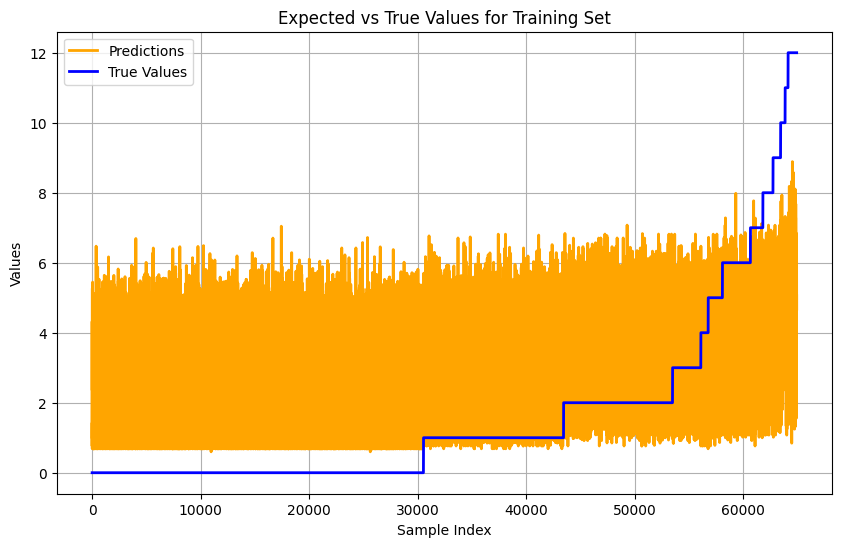

In [19]:
# Predict and evaluate
predictions = model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_train)
sorted_y_train = y_train[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_train, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Training Set')
plt.legend()
plt.grid(True)
plt.show()

### Show results - Validation set

Mean Squared Error: 6.80


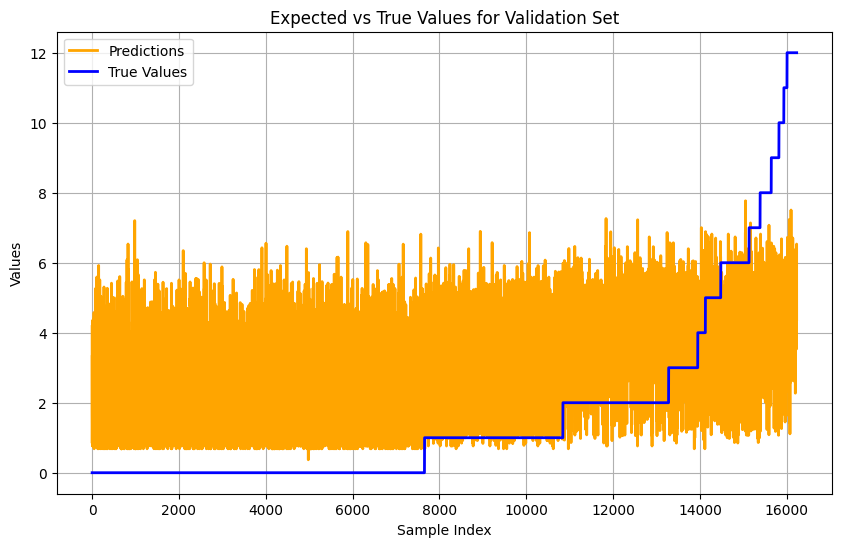

In [20]:
# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_val)
sorted_y_val = y_val[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_val, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Validation Set')
plt.legend()
plt.grid(True)
plt.show()

### Predictions - next gameweek

Mean Squared Error: 4.17


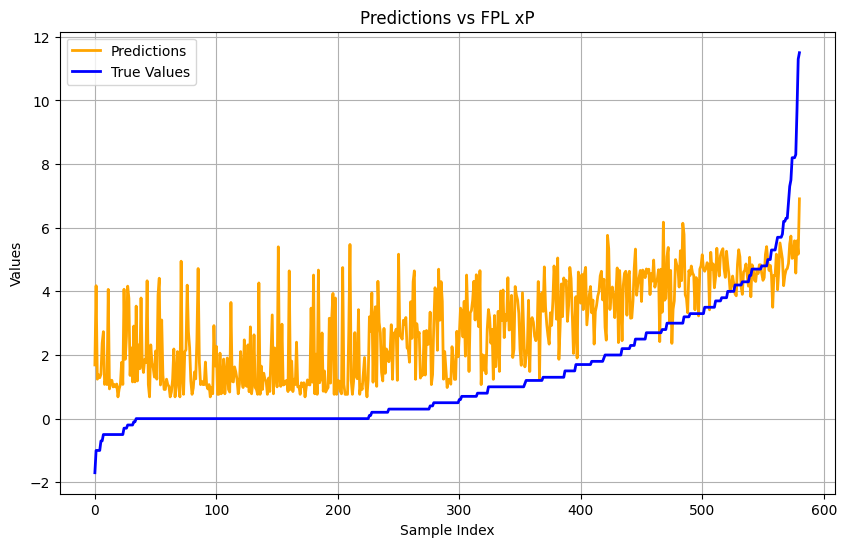

In [21]:
# Get test data
X_test = X_test_games[0]
X_test = scaler.transform(X_test)
y_test = eP_games[0]
player_ids_test = player_names_games[0]

# Make predictions on the test data
predictions = model.predict(X_test)
mse = mean_squared_error(eP_games[0], predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(eP_games[0])
sorted_ep = eP_games[0][sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_ep, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Predictions vs FPL xP')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Sum predicted scores for next 5 gameweeks
predictions_5 = []
for i in range(5):
    X_test = X_test_games[i]
    X_test = scaler.transform(X_test)
    predictions_5.append(model.predict(X_test))
predictions_sum = np.sum(np.array(predictions_5), axis=0)

# Highest predictions (top 10)
top_10_indices = np.argsort(predictions)[-10:][::-1]

# Prepare data for top 10 predictions table
top_10_data = []
for num, i in enumerate(top_10_indices):
    name = player_overall_stats[name_to_id[player_ids_test[i]]]['web_name']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    top_10_data.append([num + 1, name, f'{predictions[i]:.2f}', f'{y_test[i]:.2f}', 
                        f'{predictions_sum[i]:.2f}', f'{play_chance}'])

# Print the top 10 predictions as a table
print("Top 10 Highest Predicted Players:")
print(tabulate(top_10_data, headers=["Rank", "Player", "Predicted Score", "FPL xP", 
                                     "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

# Initialize an empty dictionary to store top 5 players for each position
top_players_by_position = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

# Iterate through each player, filtering by position and appending the data
for i in range(len(predictions)):
    player_id = name_to_id[player_ids_test[i]]
    pp = player_overall_stats[player_id]
    position = pp['element_type']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    
    # Store the player data as a tuple and append to corresponding position
    player_data = (predictions[i], y_test[i], pp['web_name'], predictions_sum[i], play_chance)
    top_players_by_position[position_mapping[position]].append(player_data)

# Sort and extract top 5 players for each position
for position, players in top_players_by_position.items():
    # Sort by predicted score in descending order
    players_sorted = sorted(players, key=lambda x: x[0], reverse=True)
    
    # Get top 5 players
    top_5 = players_sorted[:5]
    
    print(f"\nTop 5 for {position}:")
    position_data = []
    for num, player in enumerate(top_5, 1):
        predicted_score, actual_score, web_name, sum5, play_chance = player
        position_data.append([num, web_name, f'{predicted_score:.2f}', f'{actual_score:.2f}', f'{sum5:.2f}',
                             f'{play_chance}'])
    
    # Print position-specific table
    print(tabulate(position_data, headers=["Rank", "Player", "Predicted Score", "FPL xP",
                                           "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

Top 10 Highest Predicted Players:
+------+-------------+-----------------+--------+------------------+-------------------+
| Rank |   Player    | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+------+-------------+-----------------+--------+------------------+-------------------+
|  1   |   M.Salah   |      6.91       | 11.50  |      34.23       |       None        |
|  2   |   Palmer    |      6.17       |  2.80  |      30.74       |        100        |
|  3   |   Haaland   |      6.14       |  3.00  |      30.79       |        100        |
|  4   |   Watkins   |      5.79       |  3.20  |      28.50       |        100        |
|  5   |    Foden    |      5.76       |  2.00  |      28.81       |        100        |
|  6   |    Saka     |      5.74       |  7.50  |      28.69       |        100        |
|  7   |   Solanke   |      5.59       |  8.20  |      27.95       |        100        |
|  8   | B.Fernandes |      5.59       |  9.70  |      27.50       |        

In [23]:
# Highest predictions (top 10)
top_10_indices = np.argsort(predictions_sum.flatten())[-10:][::-1]

# Prepare data for top 10 predictions table
top_10_data = []
for num, i in enumerate(top_10_indices):
    name = player_overall_stats[name_to_id[player_ids_test[i]]]['web_name']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    top_10_data.append([num + 1, name, f'{predictions[i]:.2f}', f'{y_test[i]:.2f}', 
                        f'{predictions_sum[i]:.2f}', f'{play_chance}'])

# Print the top 10 predictions as a table
print("Top 10 Highest Predicted Players, sorted by sum of next 5 games:")
print(tabulate(top_10_data, headers=["Rank", "Player", "Predicted Score", "FPL xP", 
                                     "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

# Initialize an empty dictionary to store top 5 players for each position
top_players_by_position = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

# Iterate through each player, filtering by position and appending the data
for i in range(len(predictions)):
    player_id = name_to_id[player_ids_test[i]]
    pp = player_overall_stats[player_id]
    position = pp['element_type']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    
    # Store the player data as a tuple and append to corresponding position
    player_data = (predictions[i], y_test[i], pp['web_name'], predictions_sum[i], play_chance)
    top_players_by_position[position_mapping[position]].append(player_data)

# Sort and extract top 5 players for each position
for position, players in top_players_by_position.items():
    # Sort by predicted score in descending order
    players_sorted = sorted(players, key=lambda x: x[3], reverse=True)
    
    # Get top 5 players
    top_5 = players_sorted[:5]
    
    print(f"\nTop 5 for {position}:")
    position_data = []
    for num, player in enumerate(top_5, 1):
        predicted_score, actual_score, web_name, sum5, play_chance = player
        position_data.append([num, web_name, f'{predicted_score:.2f}', f'{actual_score:.2f}', f'{sum5:.2f}',
                             f'{play_chance}'])
    
    # Print position-specific table
    print(tabulate(position_data, headers=["Rank", "Player", "Predicted Score", "FPL xP",
                                           "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

Top 10 Highest Predicted Players, sorted by sum of next 5 games:
+------+-------------+-----------------+--------+------------------+-------------------+
| Rank |   Player    | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+------+-------------+-----------------+--------+------------------+-------------------+
|  1   |   M.Salah   |      6.91       | 11.50  |      34.23       |       None        |
|  2   |   Haaland   |      6.14       |  3.00  |      30.79       |        100        |
|  3   |   Palmer    |      6.17       |  2.80  |      30.74       |        100        |
|  4   |    Foden    |      5.76       |  2.00  |      28.81       |        100        |
|  5   |    Saka     |      5.74       |  7.50  |      28.69       |        100        |
|  6   |   Watkins   |      5.79       |  3.20  |      28.50       |        100        |
|  7   |   Solanke   |      5.59       |  8.20  |      27.95       |        100        |
|  8   |    Wissa    |      5.52       |  5.7

### Load my team data

In [24]:
user_id = 10581845
url = f'https://fantasy.premierleague.com/api/entry/{user_id}/event/{11}/picks/'

response = requests.get(url)
data = response.json()

In [25]:
# Prepare a mapping of positions
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
grouped_data = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

# Populate grouped data based on position
for player in data['picks']:
    player_name = id_dict[str(player["element"])]
    name = player_overall_stats[str(player['element'])]['web_name']
    prediction = predictions[player_ids_test.index(player_name)]
    sum5 = predictions_sum[player_ids_test.index(player_name)]
    fpl_xp = y_test[player_ids_test.index(player_name)]
    player_position = position_mapping[player_overall_stats[str(player['element'])]['element_type']]
    grouped_data[player_position].append([name, f"{prediction:.2f}", f'{fpl_xp:.2f}', f"{sum5:.2f}"])

# Combine to one table
combined_data = []
for position, players in grouped_data.items():
    combined_data.append([f"--- {position} ---", "", "", ""])
    for player in players:
        combined_data.append(player)

# Print the combined table
print('Current squad')
print(tabulate(combined_data, headers=['Player Name', 'Predicted Score', "FPL xP", 'Sum next 5 games'], tablefmt="pretty"))

Current squad
+-------------+-----------------+--------+------------------+
| Player Name | Predicted Score | FPL xP | Sum next 5 games |
+-------------+-----------------+--------+------------------+
| --- GK ---  |                 |        |                  |
|    Raya     |      5.34       |  3.80  |      26.70       |
|  Fabianski  |      4.83       |  4.70  |      23.94       |
| --- DEF --- |                 |        |                  |
|   Gabriel   |      5.26       |  3.80  |      26.30       |
|  Aït-Nouri  |      4.83       |  3.00  |      23.82       |
|   Pinnock   |      4.58       |  2.70  |      22.85       |
|    Evans    |      3.37       |  0.70  |      16.16       |
| Kristiansen |      3.72       |  0.70  |      19.21       |
| --- MID --- |                 |        |                  |
|   Johnson   |      5.02       |  5.80  |      25.09       |
|    Foden    |      5.76       |  2.00  |      28.81       |
|   M.Salah   |      6.91       | 11.50  |      34.23   

### Optimization problem

**Constraints**

Squad constraints:
- 2 GK, 5 DEF, 5 MID, 3 FWD in squad (15 players total)
- Max 3 players from each team in squad

Start 11 constraints:
- Exactly 1 GK
- At least 3 DEF
- At least 2 MID
- At least 1 FWD
- Exactly 11 players total

Transfer constraints:
- Must not exceed total bank balance
- Cost of extra transfers

**Optimization**

- Optimize points scored by start 11
- Include points for following gameweeks
- Prioritise not to make transfers if little/no points gain (to save transfers for next rounds)

In [30]:
squad = []
for player in data['picks']:
    squad.append(str(player['element']))

In [31]:
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
players = []

for key, value in player_overall_stats.items():
    
    # Skip if no prediction for player
    if not id_dict[key] in player_ids_test:
        continue
        
    # Add player stats
    p = {"id": key,
         "name": value['web_name'],
         "position": position_mapping[value['element_type']],
         "team": value['team'], 
         "cost": value['now_cost'],
         "play_chance": value['chance_of_playing_next_round']
        }
    
    # Add predicted points
    predicted_index = player_ids_test.index(id_dict[key])
    p["pred_points"] = predictions[predicted_index]
    
    # Add in squad or not
    if key in squad:
        p["in_current_squad"] = 1
    else:
        p["in_current_squad"] = 0
        
    players.append(p)

In [32]:
# Parameters
bank_balance = data['entry_history']['bank']  # Money left in bank
free_transfers = 1  # Number of free transfers available - find out where to use API for this

# Create problem
prob = pulp.LpProblem("FPL_Team_Optimization", pulp.LpMaximize)

# Decision variables
x = {p['id']: pulp.LpVariable(f"x_{p['id']}", cat="Binary") for p in players}  # Squad selection
y = {p['id']: pulp.LpVariable(f"y_{p['id']}", cat="Binary") for p in players}  # Starting 11 selection
extra_transfers = pulp.LpVariable("extra_transfers_var", lowBound=0, cat="Continuous")

# Objective function: Maximize expected points of the starting 11 minus cost of extra transfers
prob += (pulp.lpSum(y[p['id']] * p['pred_points'] for p in players) - 4*extra_transfers)

# Constraints
# Squad size and composition
prob += pulp.lpSum(x[p['id']] for p in players) == 15
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "GK") == 2
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "DEF") == 5
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "MID") == 5
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "FWD") == 3

# Max 3 players per team
teams = set(p['team'] for p in players)
for team in teams:
    prob += pulp.lpSum(x[p['id']] for p in players if p['team'] == team) <= 3

# Starting 11 composition
prob += pulp.lpSum(y[p['id']] for p in players) == 11
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "GK") == 1
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "DEF") >= 3
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "MID") >= 2
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "FWD") >= 1

# Starting 11 must be in squad
for p in players:
    prob += y[p['id']] <= x[p['id']]

# Transfer cost and budget
total_cost = pulp.lpSum(p['cost'] * (x[p['id']] - p['in_current_squad']) for p in players)
prob += total_cost <= bank_balance

# Add
total_transfers = pulp.lpSum(x[p['id']] for p in players if p['in_current_squad'] == 0)
prob += extra_transfers >= total_transfers - free_transfers
prob += extra_transfers >= 0

# Solve
prob.solve()

# Extract results
selected_squad = [p for p in players if pulp.value(x[p['id']]) > 0.5]
starting_11 = [p for p in players if pulp.value(y[p['id']]) > 0.5]
transfers_in = [p for p in players if pulp.value(x[p['id']]) > 0.5 and p['in_current_squad'] == 0]
transfers_out = [p for p in players if pulp.value(x[p['id']]) < 0.5 and p['in_current_squad'] == 1]

In [33]:
print(f'Transfers in: {list(t["name"] for t in transfers_in)}')
print(f'Transfers out: {list(t["name"] for t in transfers_out)}')

Transfers in: ['Lewis']
Transfers out: ['Kristiansen']


In [34]:
# Prepare a mapping of positions
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
grouped_data = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

# Populate grouped data based on position
for player in selected_squad:
    player_name = player['name']
    prediction = player['pred_points']
    sum5 = predictions_sum[player_ids_test.index(id_dict[player['id']])]
    fpl_xp = y_test[player_ids_test.index(id_dict[player['id']])]
    player_position = player['position']
    play_chance = player['play_chance']
    grouped_data[player_position].append([player_name, f"{prediction:.2f}", f'{fpl_xp:.2f}', f"{sum5:.2f}", f"{play_chance}"])

# Combine to one table
combined_data = []
for position, players in grouped_data.items():
    combined_data.append([f"--- {position} ---", "", "", ""])
    for player in players:
        combined_data.append(player)

# Print the combined table
print('New squad')
print(tabulate(combined_data, headers=['Player Name', 'Predicted Score', "FPL xP", 'Sum next 5 games',
                                       'Chance of playing'], tablefmt="pretty"))

New squad
+-------------+-----------------+--------+------------------+-------------------+
| Player Name | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+-------------+-----------------+--------+------------------+-------------------+
| --- GK ---  |                 |        |                  |                   |
|    Raya     |      5.34       |  3.80  |      26.70       |        100        |
|  Fabianski  |      4.83       |  4.70  |      23.94       |       None        |
| --- DEF --- |                 |        |                  |                   |
|   Gabriel   |      5.26       |  3.80  |      26.30       |        100        |
|   Pinnock   |      4.58       |  2.70  |      22.85       |        100        |
|    Lewis    |      5.17       |  0.30  |      26.07       |       None        |
|    Evans    |      3.37       |  0.70  |      16.16       |        100        |
|  Aït-Nouri  |      4.83       |  3.00  |      23.82       |        100        |
| --- 

In [38]:
# Prepare a mapping of positions
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
grouped_data = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

highest_prediction = 0
gw_points = 0
for player in starting_11:
    gw_points += player['pred_points']
    if player['pred_points'] > highest_prediction:
        highest_prediction = player['pred_points']
gw_points += highest_prediction

# Populate grouped data based on position
for player in starting_11:
    player_name = player['name']
    if player['pred_points'] == highest_prediction:
        player_name = player_name + " (C)"
    prediction = player['pred_points']
    sum5 = predictions_sum[player_ids_test.index(id_dict[player['id']])]
    fpl_xp = y_test[player_ids_test.index(id_dict[player['id']])]
    player_position = player['position']
    play_chance = player['play_chance']
    grouped_data[player_position].append([player_name, f"{prediction:.2f}", f'{fpl_xp:.2f}', f"{sum5:.2f}", f"{play_chance}"])

# Combine to one table
combined_data = []
for position, players in grouped_data.items():
    combined_data.append([f"--- {position} ---", "", "", ""])
    for player in players:
        combined_data.append(player)

# Print the combined table
print('Starting 11')
print(tabulate(combined_data, headers=['Player Name', 'Predicted Score', "FPL xP", 'Sum next 5 games',
                                       'Chance of playing'], tablefmt="pretty"))

print(f'Expected points next gameweek: {gw_points:.2f}')

Starting 11
+-------------+-----------------+--------+------------------+-------------------+
| Player Name | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+-------------+-----------------+--------+------------------+-------------------+
| --- GK ---  |                 |        |                  |                   |
|    Raya     |      5.34       |  3.80  |      26.70       |        100        |
| --- DEF --- |                 |        |                  |                   |
|   Gabriel   |      5.26       |  3.80  |      26.30       |        100        |
|    Lewis    |      5.17       |  0.30  |      26.07       |       None        |
|  Aït-Nouri  |      4.83       |  3.00  |      23.82       |        100        |
| --- MID --- |                 |        |                  |                   |
|    Saka     |      5.74       |  7.50  |      28.69       |        100        |
|   Mbeumo    |      5.12       |  3.70  |      25.62       |        100        |
| M.

### Test potential points scored if started from beginning

In [6]:
# Load data
df_all = pd.read_csv('data/all_seasons_merged.csv')
df_all = df_all.sort_values(by='kickoff_time').reset_index(drop=True)

# Split into current and previous seasons
df_prev = df_all[df_all.kickoff_date <= '2024-07-01'].drop_duplicates()
df_current = df_all[df_all.kickoff_date >= '2024-07-01'].drop_duplicates()

In [7]:
def one_hot_encode_team(team_id, num_teams):
    # Create a zero array of length num_teams
    one_hot = np.zeros(num_teams)
    
    # Set the correct index to 1 (team_id - 1 because team_id starts from 1)
    one_hot[team_id - 1] = 1

    return one_hot

# Select only numeric columns
numeric_df = df_all.select_dtypes(include='number')

# List of columns to drop
columns_to_drop = [
    'element', 'fixture', 'round', 'GW', 'id',
    'season', 'roster_id', 'player_id', 'team_id', 'opp_team_id',
    'pos_id', 'time',
    'h_goals', 'a_goals', 'team_a_score', 'team_h_score',
    ]
numeric_df = numeric_df.drop(columns=columns_to_drop)

# Choose which features to use for data
keys_to_select = list(numeric_df.columns)

In [85]:
# Load training data
X = np.load('data/xgboost/X_train_old_seasons.npy')
y = np.load('data/xgboost/y_train_old_seasons.npy')
print("Training data (X):", X.shape)
print("Target values (y):", y.shape)

# Split and scale data
y_clipped = np.clip(y, 0, 12)
X_train, X_val, y_train, y_val = train_test_split(X, y_clipped, test_size=0.2)#, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Put more weight on high-scoring players
weights = np.where(y_train > 2, 15, 1.0)

# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5)
model.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

squad = []
bank_balance = 1000
free_transfers = 15
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
total_points = 0


for i in range(1,12):
    print(f'--- Gameweek {i} ---')
    # Get current gameweek
    df_gw = df_current[df_current.GW == i]
    
    # Initialize X,y,played,players
    X_gw = []
    y_gw = []
    played_gw = []
    player_ids = []
    player_names = {}
    player_positions = {}
    player_teams = {}
    player_minutes = {}
    
    # Iterate through all players in that gameweek
    for row in df_gw.iloc:
        df_temp = df_prev[df_prev.name == row['name']][-3:]
        
        # If the player has less than 3 previous appearances, skip
        if len(df_temp) < 3:
            continue
#         if row['minutes'] == 0:
#             continue
            
        player_ids.append(str(row['element']))
        player_names[str(row['element'])] = row['name']
        player_positions[str(row['element'])] = position_mapping[row['pos_id']]
        player_teams[str(row['element'])] = row['team_id']
        player_minutes[str(row['element'])] = row['minutes']
            
        # If player played no minutes in all games
        if row['minutes']+df_temp.iloc[0]['minutes']+df_temp.iloc[1]['minutes']+df_temp.iloc[2]['minutes']==0:
            played_gw.append(0)
        else:
            played_gw.append(1)
            
        # Get one-hot encoding for players team, opp team, home/away and position
        player_team = one_hot_encode_team(row['team_id'], 27)
        opponent_team = one_hot_encode_team(row['opp_team_id'], 27)
        home_away = one_hot_encode_team(row['was_home'], 2)
        position = one_hot_encode_team(row['pos_id'], 4)
        
        # Combine into one vector
        combined_stats = np.concatenate([player_team, opponent_team, home_away, position])
        
        # Get points scored (y value)
        points = row['total_points']
        
        # Get player stats from previous games
        for j in range(3):
            row_temp = df_temp.iloc[2-j]

            # Get home/away encoding
            home_away = one_hot_encode_team(row_temp['was_home'], 2)

            # Add player team goals and opponent team goals
            if row_temp.was_home:
                score = np.array(row_temp[['team_h_score', 'team_a_score']].astype(float).values)
            else:
                score = np.array(row_temp[['team_a_score','team_h_score']].astype(float).values)

            # Select the wanted stats and convert to float numpy array
            selected_stats = np.array(row_temp[keys_to_select].astype(float).values) 

            # Combine into one vector
            combined_stats = np.concatenate([combined_stats, home_away, score, selected_stats])

        # Append combined stats to X and points (y value) to y
        X_gw.append(combined_stats)
        y_gw.append(points)
        
    # Convert lists to numpy arrays for training/testing
    X_gw = np.array(X_gw)
    y_gw = np.array(y_gw)
    played_gw = np.array(played_gw)
    print(X_gw.shape)
    
    
    # Make predictions
    X_test = scaler.transform(X_gw)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_gw, predictions)
    print(f'Mean Squared Error: {mse:.2f}')

    # Populate player info
    players = []
    for key in player_ids:
        p = {"id": key,
             "name": player_names[key],
             "position": player_positions[key],
             "team": player_teams[key],
             "cost": df_gw[df_gw.element == int(key)].iloc[0]['value'],
             "play_chance": player_minutes[key],
             "pred_points": predictions[player_ids.index(key)],
             "actual_points": df_gw[df_gw.element == int(key)].iloc[0]['total_points'],
            }
        
        # Add in squad or not
        if key in squad:
            p["in_current_squad"] = 1
        else:
            p["in_current_squad"] = 0
            
        # Update prediction if the player played 0 minutes
        if p['play_chance'] == 0:
            p['pred_points'] = 0
            
        players.append(p)
        
    # Convert 1/3 lowest predictions for each position to 0
    position_groups = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}
    for player in players:
        position_groups[player['position']].append(player)
    for position, group in position_groups.items():
        group.sort(key=lambda x: x['pred_points'])
        n_lowest = len(group) // 3
        for i in range(n_lowest):
            group[i]['pred_points'] = 0
    players = [player for group in position_groups.values() for player in group]
    
    # Create problem
    prob = pulp.LpProblem("FPL_Team_Optimization", pulp.LpMaximize)

    # Decision variables
    a = {p['id']: pulp.LpVariable(f"a_{p['id']}", cat="Binary") for p in players}  # Squad selection
    b = {p['id']: pulp.LpVariable(f"b_{p['id']}", cat="Binary") for p in players}  # Starting 11 selection
    extra_transfers = pulp.LpVariable("extra_transfers_var", lowBound=0, cat="Continuous")

    # Objective function: Maximize expected points of the starting 11 minus cost of extra transfers
    prob += (pulp.lpSum(b[p['id']] * p['pred_points'] for p in players) - 4 * extra_transfers)

    # Constraints
    # Squad size and composition
    prob += pulp.lpSum(a[p['id']] for p in players) == 15
    prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "GK") == 2
    prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "DEF") == 5
    prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "MID") == 5
    prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "FWD") == 3

    # Max 3 players per team
    teams = set(p['team'] for p in players)
    for team in teams:
        prob += pulp.lpSum(a[p['id']] for p in players if p['team'] == team) <= 3

    # Starting 11 composition
    prob += pulp.lpSum(b[p['id']] for p in players) == 11
    prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "GK") == 1
    prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "DEF") >= 3
    prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "MID") >= 2
    prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "FWD") >= 1

    # Starting 11 must be in squad
    for p in players:
        prob += b[p['id']] <= a[p['id']]

    # Transfer cost and budget
    total_cost = pulp.lpSum(p['cost'] * (a[p['id']] - p['in_current_squad']) for p in players)
    prob += total_cost <= bank_balance

    # Add
    total_transfers = pulp.lpSum(a[p['id']] for p in players if p['in_current_squad'] == 0)
    prob += extra_transfers >= total_transfers - free_transfers
    prob += extra_transfers >= 0

    # Solve
    prob.solve()


    if prob.status != pulp.LpStatusOptimal:
        raise ValueError("Optimization did not find a feasible solution.")

    # Extract results
    selected_squad = [p for p in players if pulp.value(a[p['id']]) > 0.5]
    starting_11 = [p for p in players if pulp.value(b[p['id']]) > 0.5]
    transfers_in = [p for p in players if pulp.value(a[p['id']]) > 0.5 and p['in_current_squad'] == 0]
    transfers_out = [p for p in players if pulp.value(a[p['id']]) < 0.5 and p['in_current_squad'] == 1]

    
    # Print results
    print(f'Transfers in: {list(t["name"] for t in transfers_in)}')
    print(f'Transfers out: {list(t["name"] for t in transfers_out)}')
    
    # Prepare a mapping of positions
    position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    grouped_data = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

    # Populate grouped data based on position
    for player in selected_squad:
        player_name = player['name']
        prediction = player['pred_points']
        actual_points = player['actual_points']
        player_position = player['position']
        play_chance = player['play_chance']
        grouped_data[player_position].append([player_name, f"{prediction:.2f}", f'{actual_points}', f"{play_chance}"])

    # Combine to one table
    combined_data = []
    for position, players_pos in grouped_data.items():
        combined_data.append([f"--- {position} ---", "", "", ""])
        for player in players_pos:
            combined_data.append(player)

    # Print the combined table
    print('New squad')
    print(tabulate(combined_data,headers=['Player Name', 'Predicted Score', 'Actual points', 'Chance of playing'],
                   tablefmt="pretty"))
    
    # Prepare a mapping of positions
    position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    grouped_data = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

    # Populate grouped data based on position
    for player in starting_11:
        player_name = player['name']
        prediction = player['pred_points']
        actual_points = player['actual_points']
        player_position = player['position']
        play_chance = player['play_chance']
        grouped_data[player_position].append([player_name, f"{prediction:.2f}", f'{actual_points}', f"{play_chance}"])

    # Combine to one table
    combined_data = []
    for position, players_pos in grouped_data.items():
        combined_data.append([f"--- {position} ---", "", "", ""])
        for player in players_pos:
            combined_data.append(player)

    # Print the combined table
    print('Starting 11')
    print(tabulate(combined_data,headers=['Player Name', 'Predicted Score', 'Actual points', 'Chance of playing'],
                   tablefmt="pretty"))
    
    
    
    # Update parameters
    for player in transfers_in:
        bank_balance -= player['cost']
        free_transfers -= 1
        squad.append(player['id'])
    for player in transfers_out:
        bank_balance += player['cost']
        squad.remove(player['id'])
        
    free_transfers = min(max(free_transfers, 0) + 1, 5)
    
    print(f'New bank balance = {bank_balance}')
    print(f'New free transfers = {free_transfers}')
    print(f'Squad size = {len(squad)}')
    
    highest_prediction = 0
    for player in starting_11:
        if player['pred_points'] > highest_prediction:
            highest_prediction = player['pred_points']
    
    # Calculate points
    gw_points = 0
    for player in starting_11:
#         player_points = df_gw[df_gw.element == int(player['id'])].iloc[0]['total_points']
        player_points = player['actual_points']
        if player['pred_points'] == highest_prediction:
            print(f'Captain is {player["name"]}')
            player_points *= 2
        gw_points += player_points
    
    print(f'Total points in gameweek: {gw_points}')
    total_points += gw_points
    
    
    # Train new model with added data
    X = np.concatenate((X, X_gw), axis=0)
    y = np.concatenate((y, y_gw), axis=0)
    print("Training data (X):", X.shape)
    print("Target values (y):", y.shape)
    
    # Split the data into training and testing sets
    y_clipped = np.clip(y, 0, 12)
    X_train, X_val, y_train, y_val = train_test_split(X, y_clipped, test_size=0.2)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Put more weight on high-scoring players
    weights = np.where(y_train > 2, 15, 1.0)

    # Train model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5)
    model.fit(X_train, y_train, sample_weight=weights)

    # Predict and evaluate
    predictions = model.predict(X_val)
    mse = mean_squared_error(y_val, predictions)
    print(f'Mean Squared Error: {mse:.2f}')
    
        
    print('\n\n')

Training data (X): (76000, 195)
Target values (y): (76000,)
Mean Squared Error: 10.81
--- Gameweek 1 ---
(344, 195)
Mean Squared Error: 11.69
Transfers in: ['Aaron Ramsdale', 'Ederson Santana de Moraes', 'Michael Keane', 'Mason Holgate', 'Joško Gvardiol', 'Andrew Robertson', 'Virgil van Dijk', 'Ethan Nwaneri', 'Son Heung-Min', 'Anthony Gordon', 'Cole Palmer', 'Phil Foden', 'Jean-Philippe Mateta', 'João Pedro Junqueira de Jesus', 'Alexander Isak']
Transfers out: []
New squad
+-------------------------------+-----------------+---------------+-------------------+
|          Player Name          | Predicted Score | Actual points | Chance of playing |
+-------------------------------+-----------------+---------------+-------------------+
|          --- GK ---           |                 |               |                   |
|        Aaron Ramsdale         |      0.00       |       0       |         0         |
|   Ederson Santana de Moraes   |      5.67       |       8       |        90    

Mean Squared Error: 10.68



--- Gameweek 3 ---
(350, 195)
Mean Squared Error: 13.46
Transfers in: ['Yoane Wissa']
Transfers out: ['Jean-Philippe Mateta']
New squad
+-------------------------------+-----------------+---------------+-------------------+
|          Player Name          | Predicted Score | Actual points | Chance of playing |
+-------------------------------+-----------------+---------------+-------------------+
|          --- GK ---           |                 |               |                   |
|        Aaron Ramsdale         |      2.48       |       2       |        90         |
|   Ederson Santana de Moraes   |      4.51       |       2       |        90         |
|          --- DEF ---          |                 |               |                   |
|         Mason Holgate         |      0.00       |       0       |         0         |
|         Michael Keane         |      2.20       |       6       |        90         |
|        Virgil van Dijk        |      6.27

Mean Squared Error: 10.71



--- Gameweek 6 ---
(351, 195)
Mean Squared Error: 15.25
Transfers in: ['Bryan Mbeumo', 'Nicolas Jackson']
Transfers out: ['Son Heung-Min', 'Alexander Isak']
New squad
+---------------------------+-----------------+---------------+-------------------+
|        Player Name        | Predicted Score | Actual points | Chance of playing |
+---------------------------+-----------------+---------------+-------------------+
|        --- GK ---         |                 |               |                   |
|      Aaron Ramsdale       |      0.00       |       2       |        90         |
| Ederson Santana de Moraes |      5.52       |       2       |        90         |
|        --- DEF ---        |                 |               |                   |
|       Mason Holgate       |      0.00       |       0       |         0         |
|       Michael Keane       |      0.00       |       0       |         0         |
|      Joško Gvardiol       |      5.93       | 

Mean Squared Error: 10.96



--- Gameweek 9 ---
(351, 195)
Mean Squared Error: 12.71
Transfers in: ['Dejan Kulusevski']
Transfers out: ['Anthony Gordon']
New squad
+---------------------------+-----------------+---------------+-------------------+
|        Player Name        | Predicted Score | Actual points | Chance of playing |
+---------------------------+-----------------+---------------+-------------------+
|        --- GK ---         |                 |               |                   |
|      Aaron Ramsdale       |      3.21       |       4       |        90         |
| Ederson Santana de Moraes |      5.22       |       6       |        90         |
|        --- DEF ---        |                 |               |                   |
|       Mason Holgate       |      0.00       |       0       |         0         |
|       Michael Keane       |      2.55       |       2       |        90         |
|     Andrew Robertson      |      5.94       |       1       |        62       

Mean Squared Error: 10.88





In [86]:
total_points

678

In [40]:
# Make predictions
X_test = scaler.transform(X_gw)
predictions = model.predict(X_test)
mse = mean_squared_error(y_gw, predictions)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 13.14


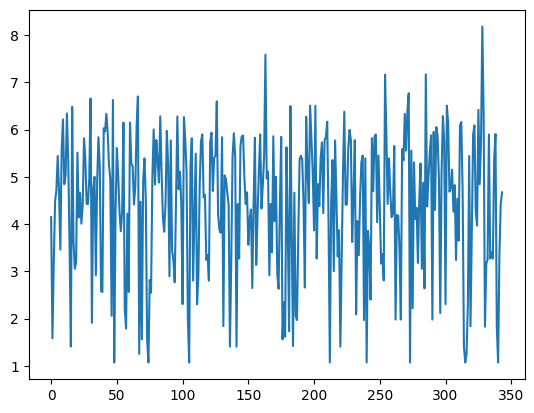

In [70]:
plt.plot(predictions)

In [79]:
# Populate player info
players = []
for key in player_ids:
    p = {"id": key,
         "name": player_names[key],
         "position": player_positions[key],
         "team": player_teams[key],
         "cost": df_gw[df_gw.element == int(key)].iloc[0]['value'],
         "play_chance": player_minutes[key],
         "pred_points": predictions[player_ids.index(key)],
         "actual_points": df_gw[df_gw.element == int(key)].iloc[0]['total_points'],
        }

    # Add in squad or not
    if key in squad:
        p["in_current_squad"] = 1
    else:
        p["in_current_squad"] = 0

#     # Update prediction if the player played 0 minutes
#     if p['play_chance'] == 0:
#         p['pred_points'] = 0

    players.append(p)
print(len(players))

344


In [80]:
# Group players by position
position_groups = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

for player in players:
    position_groups[player['position']].append(player)

# Process each position group
for position, group in position_groups.items():
    # Sort players by predicted points (ascending)
    group.sort(key=lambda x: x['pred_points'])
    
    # Find the index threshold for the lowest 1/3
    n_lowest = len(group) // 3
    
    # Set the lowest 1/3 predictions to 0
    for i in range(n_lowest):
        group[i]['pred_points'] = 0

# Flatten the grouped list back into the `players` list
players = [player for group in position_groups.values() for player in group]
print(len(players))

344


In [81]:
predictions_2 = []
for p in players:
    predictions_2.append(p['pred_points'])
predictions_2 = np.array(predictions_2)

In [82]:
len(predictions_2), sum(predictions_2==0)

(344, 113)

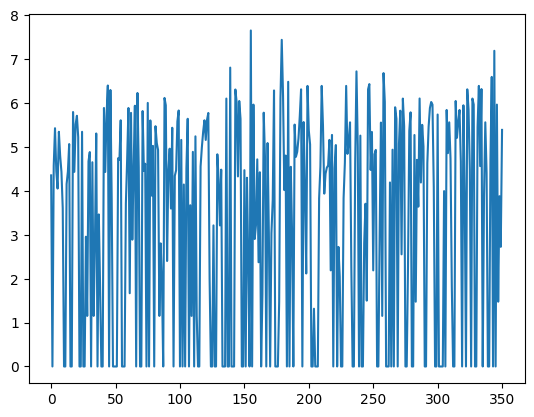

In [45]:
plt.plot(predictions_2)

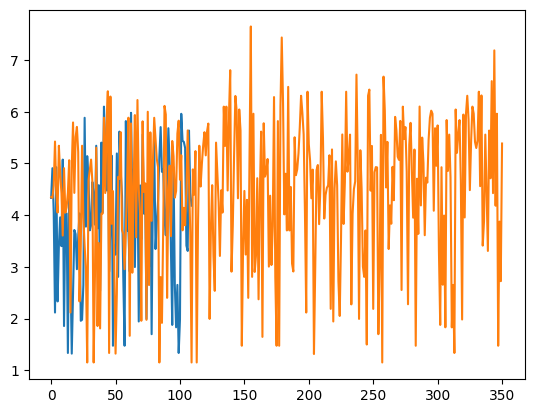

In [51]:
plt.figure()
plt.plot(predictions[np.array(predictions_2)==0])
plt.plot(predictions)

In [37]:
weight_scores_temp = []
weight = 15

for k in range(200):
    print(k)
    
    # Load training data
    X = np.load('data/xgboost/X_train_old_seasons.npy')
    y = np.load('data/xgboost/y_train_old_seasons.npy')

    # Split and scale data
    y_clipped = np.clip(y, 0, 12)
    X_train, X_val, y_train, y_val = train_test_split(X, y_clipped, test_size=0.2)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Put more weight on high-scoring players
    weights = np.where(y_train > 2, weight, 1.0)

    # Train model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5)
    model.fit(X_train, y_train, sample_weight=weights)

#     # Predict and evaluate
#     predictions = model.predict(X_val)
#     mse = mean_squared_error(y_val, predictions)

    squad = []
    bank_balance = 1000
    free_transfers = 15
    position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    total_points = 0


    for i in range(1,12):
        # Get current gameweek
        df_gw = df_current[df_current.GW == i]
        
        df_next1 = df_current[df_current.GW == i+1]
        df_next2 = df_current[df_current.GW == i+2]
        df_next3 = df_current[df_current.GW == i+3]
        
        if len(df_next1) == 0:
            df_next1 = df_gw.copy()
        if len(df_next2) == 0:
            df_next2 = df_next1.copy()
        if len(df_next3) == 0:
            df_next3 = df_next2.copy()

        # Initialize X,y,played,players
        X_gw = []
        X_gw_next1 = []
        X_gw_next2 = []
        X_gw_next3 = []
        y_gw = []
        played_gw = []
        player_ids = []
        player_names = {}
        player_positions = {}
        player_teams = {}
        player_minutes = {}

        # Iterate through all players in that gameweek
        for row in df_gw.iloc:
            df_temp = df_prev[df_prev.name == row['name']][-3:]

            # If the player has less than 3 previous appearances, skip
            if len(df_temp) < 3:
                continue

            player_ids.append(str(row['element']))
            player_names[str(row['element'])] = row['name']
            player_positions[str(row['element'])] = position_mapping[row['pos_id']]
            player_teams[str(row['element'])] = row['team_id']
            player_minutes[str(row['element'])] = row['minutes']

            # If player played no minutes in all games
            if row['minutes']+df_temp.iloc[0]['minutes']+df_temp.iloc[1]['minutes']+df_temp.iloc[2]['minutes']==0:
                played_gw.append(0)
            else:
                played_gw.append(1)

            # Get one-hot encoding for players team, opp team, home/away and position
            player_team = one_hot_encode_team(row['team_id'], 27)
            opponent_team = one_hot_encode_team(row['opp_team_id'], 27)
            home_away = one_hot_encode_team(row['was_home'], 2)
            position = one_hot_encode_team(row['pos_id'], 4)
            
            # For the following 3 games
            row_next1 = df_next1[df_next1.name == row['name']]
            row_next2 = df_next2[df_next2.name == row['name']]
            row_next3 = df_next3[df_next3.name == row['name']]
            
            opponent_team_next1 = one_hot_encode_team(row_next1['opp_team_id'], 27)
            opponent_team_next2 = one_hot_encode_team(row_next2['opp_team_id'], 27)
            opponent_team_next3 = one_hot_encode_team(row_next3['opp_team_id'], 27)
            
            home_away_next1 = one_hot_encode_team(row_next1['was_home'], 2)
            home_away_next2 = one_hot_encode_team(row_next2['was_home'], 2)
            home_away_next3 = one_hot_encode_team(row_next3['was_home'], 2)

            # Combine into one vector
            combined_stats = np.concatenate([player_team, opponent_team, home_away, position])
            combined_stats_next1 = np.concatenate([player_team, opponent_team_next1, home_away_next1, position])
            combined_stats_next2 = np.concatenate([player_team, opponent_team_next2, home_away_next2, position])
            combined_stats_next3 = np.concatenate([player_team, opponent_team_next2, home_away_next2, position])

            # Get points scored (y value)
            points = row['total_points']

            # Get player stats from previous games
            for j in range(3):
                row_temp = df_temp.iloc[2-j]

                # Get home/away encoding
                home_away = one_hot_encode_team(row_temp['was_home'], 2)

                # Add player team goals and opponent team goals
                if row_temp.was_home:
                    score = np.array(row_temp[['team_h_score', 'team_a_score']].astype(float).values)
                else:
                    score = np.array(row_temp[['team_a_score','team_h_score']].astype(float).values)

                # Select the wanted stats and convert to float numpy array
                selected_stats = np.array(row_temp[keys_to_select].astype(float).values) 

                # Combine into one vector
                combined_stats = np.concatenate([combined_stats, home_away, score, selected_stats])
                combined_stats_next1 = np.concatenate([combined_stats_next1, home_away, score, selected_stats])
                combined_stats_next2 = np.concatenate([combined_stats_next2, home_away, score, selected_stats])
                combined_stats_next3 = np.concatenate([combined_stats_next3, home_away, score, selected_stats])

            # Append combined stats to X and points (y value) to y
            X_gw.append(combined_stats)
            X_gw_next1.append(combined_stats_next1)
            X_gw_next2.append(combined_stats_next2)
            X_gw_next3.append(combined_stats_next3)
            y_gw.append(points)

        # Convert lists to numpy arrays for training/testing
        X_gw = np.array(X_gw)
        X_gw_next1 = np.array(X_gw_next1)
        X_gw_next2 = np.array(X_gw_next2)
        X_gw_next3 = np.array(X_gw_next3)
        y_gw = np.array(y_gw)
        played_gw = np.array(played_gw)

        # Make predictions
        X_test = scaler.transform(X_gw)
        X_test_next1 = scaler.transform(X_gw_next1)
        X_test_next2 = scaler.transform(X_gw_next2)
        X_test_next3 = scaler.transform(X_gw_next3)
        predictions = model.predict(X_test)
        predictions_next1 = model.predict(X_test_next1)
        predictions_next2 = model.predict(X_test_next2)
        predictions_next3 = model.predict(X_test_next3)
#         mse = mean_squared_error(y_gw, predictions)

        # Populate player info
        players = []
        for key in player_ids:
            p = {"id": key,
                 "name": player_names[key],
                 "position": player_positions[key],
                 "team": player_teams[key],
                 "cost": df_gw[df_gw.element == int(key)].iloc[0]['value'],
                 "play_chance": player_minutes[key],
                 "pred_points": predictions[player_ids.index(key)],
                 "pred_points_next1": predictions_next1[player_ids.index(key)],
                 "pred_points_next2": predictions_next1[player_ids.index(key)],
                 "pred_points_next3": predictions_next1[player_ids.index(key)],
                 "actual_points": df_gw[df_gw.element == int(key)].iloc[0]['total_points'],
                }

            # Add in squad or not
            if key in squad:
                p["in_current_squad"] = 1
            else:
                p["in_current_squad"] = 0

            # Update prediction if the player played 0 minutes
            if p['play_chance'] == 0:
                p['pred_points'] = 0
            players.append(p)

        # Create problem
        prob = pulp.LpProblem("FPL_Team_Optimization", pulp.LpMaximize)

        # Decision variables
        a = {p['id']: pulp.LpVariable(f"a_{p['id']}", cat="Binary") for p in players}  # Squad selection
        b = {p['id']: pulp.LpVariable(f"b_{p['id']}", cat="Binary") for p in players}  # Starting 11 selection
        extra_transfers = pulp.LpVariable("extra_transfers_var", lowBound=0, cat="Continuous")
        
        c = {p['id']: pulp.LpVariable(f"c_{p['id']}", cat="Binary") for p in players}  # Starting 11 next game
        d = {p['id']: pulp.LpVariable(f"d_{p['id']}", cat="Binary") for p in players}  # Starting 11 next next game
        e = {p['id']: pulp.LpVariable(f"e_{p['id']}", cat="Binary") for p in players}  # Starting 11 next next next game

        # Objective function: Maximize expected points of the starting 11 minus cost of extra transfers
#         prob += (pulp.lpSum(b[p['id']] * p['pred_points'] for p in players) - 4 * extra_transfers)
        prob += (
            pulp.lpSum(b[p['id']] * p['pred_points'] for p in players) + 
            0.5 * pulp.lpSum(c[p['id']] * p['pred_points_next1'] for p in players) +
            0.25 * pulp.lpSum(d[p['id']] * p['pred_points_next2'] for p in players) +
            0.25 * pulp.lpSum(e[p['id']] * p['pred_points_next3'] for p in players) -
            8 * extra_transfers
        )


        # Constraints
        # Squad size and composition
        prob += pulp.lpSum(a[p['id']] for p in players) == 15
        prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "GK") == 2
        prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "DEF") == 5
        prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "MID") == 5
        prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "FWD") == 3

        # Max 3 players per team
        teams = set(p['team'] for p in players)
        for team in teams:
            prob += pulp.lpSum(a[p['id']] for p in players if p['team'] == team) <= 3

        # Starting 11 composition
        prob += pulp.lpSum(b[p['id']] for p in players) == 11
        prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "GK") == 1
        prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "DEF") >= 3
        prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "MID") >= 2
        prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "FWD") >= 1
        
        prob += pulp.lpSum(c[p['id']] for p in players) == 11
        prob += pulp.lpSum(c[p['id']] for p in players if p['position'] == "GK") == 1
        prob += pulp.lpSum(c[p['id']] for p in players if p['position'] == "DEF") >= 3
        prob += pulp.lpSum(c[p['id']] for p in players if p['position'] == "MID") >= 2
        prob += pulp.lpSum(c[p['id']] for p in players if p['position'] == "FWD") >= 1
        
        prob += pulp.lpSum(d[p['id']] for p in players) == 11
        prob += pulp.lpSum(d[p['id']] for p in players if p['position'] == "GK") == 1
        prob += pulp.lpSum(d[p['id']] for p in players if p['position'] == "DEF") >= 3
        prob += pulp.lpSum(d[p['id']] for p in players if p['position'] == "MID") >= 2
        prob += pulp.lpSum(d[p['id']] for p in players if p['position'] == "FWD") >= 1
        
        prob += pulp.lpSum(e[p['id']] for p in players) == 11
        prob += pulp.lpSum(e[p['id']] for p in players if p['position'] == "GK") == 1
        prob += pulp.lpSum(e[p['id']] for p in players if p['position'] == "DEF") >= 3
        prob += pulp.lpSum(e[p['id']] for p in players if p['position'] == "MID") >= 2
        prob += pulp.lpSum(e[p['id']] for p in players if p['position'] == "FWD") >= 1

        # Starting 11 must be in squad
        for p in players:
            prob += b[p['id']] <= a[p['id']]
            prob += c[p['id']] <= a[p['id']]
            prob += d[p['id']] <= a[p['id']]
            prob += e[p['id']] <= a[p['id']]

        # Transfer cost and budget
        total_cost = pulp.lpSum(p['cost'] * (a[p['id']] - p['in_current_squad']) for p in players)
        prob += total_cost <= bank_balance

        # Add
        total_transfers = pulp.lpSum(a[p['id']] for p in players if p['in_current_squad'] == 0)
        prob += extra_transfers >= total_transfers - free_transfers
        prob += extra_transfers >= 0

        # Solve
        prob.solve()

        if prob.status != pulp.LpStatusOptimal:
            raise ValueError("Optimization did not find a feasible solution.")

        # Extract results
        selected_squad = [p for p in players if pulp.value(a[p['id']]) > 0.5]
        starting_11 = [p for p in players if pulp.value(b[p['id']]) > 0.5]
        transfers_in = [p for p in players if pulp.value(a[p['id']]) > 0.5 and p['in_current_squad'] == 0]
        transfers_out = [p for p in players if pulp.value(a[p['id']]) < 0.5 and p['in_current_squad'] == 1]


        # Update parameters
        for player in transfers_in:
            bank_balance -= player['cost']
            free_transfers -= 1
            squad.append(player['id'])
        for player in transfers_out:
            bank_balance += player['cost']
            squad.remove(player['id'])

        free_transfers = min(max(free_transfers, 0) + 1, 5)

        highest_prediction = 0
        for player in starting_11:
            if player['pred_points'] > highest_prediction:
                highest_prediction = player['pred_points']

        # Calculate points
        gw_points = 0
        for player in starting_11:
            player_points = player['actual_points']
            if player['pred_points'] == highest_prediction:
                player_points *= 2
            gw_points += player_points

        print(f'GW {i} points: {gw_points}')
        total_points += gw_points


        # Train new model with added data
        X = np.concatenate((X, X_gw), axis=0)
        y = np.concatenate((y, y_gw), axis=0)

        # Split the data into training and testing sets
#         y_clipped = np.clip(y, 0, 12)
        y_clipped = np.clip(y, 0, 24)
        X_train, X_val, y_train, y_val = train_test_split(X, y_clipped, test_size=0.2)
#         X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Put more weight on high-scoring players
        weights = np.where(y_train > 2, weight, 1.0)

        # Train model
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5)
        model.fit(X_train, y_train, sample_weight=weights)

#         # Predict and evaluate
#         predictions = model.predict(X_val)
#         mse = mean_squared_error(y_val, predictions)
    
    print(f'Total points: {total_points}')
    weight_scores_temp.append(total_points)
    print(f'mean: {np.mean(weight_scores_temp):.2f}, std: {np.std(weight_scores_temp):.2f}\n')
# weight_scores[weight] = weight_scores_temp
# Save weight_scores to a pickle file
with open('data/weight_scores_temp.pkl', 'wb') as file:
    pickle.dump(weight_scores_temp, file)

0
GW 1 points: 61
GW 2 points: 79
GW 3 points: 56
GW 4 points: 23
GW 5 points: 56
GW 6 points: 92
GW 7 points: 77
GW 8 points: 58
GW 9 points: 54
GW 10 points: 39
GW 11 points: 32
Total points: 627
mean: 627.00, std: 0.00

1
GW 1 points: 53
GW 2 points: 84
GW 3 points: 35
GW 4 points: 43
GW 5 points: 61
GW 6 points: 63
GW 7 points: 47
GW 8 points: 59
GW 9 points: 74
GW 10 points: 47
GW 11 points: 48
Total points: 614
mean: 620.50, std: 6.50

2
GW 1 points: 77
GW 2 points: 78
GW 3 points: 68
GW 4 points: 56
GW 5 points: 52
GW 6 points: 62
GW 7 points: 28
GW 8 points: 36
GW 9 points: 55
GW 10 points: 28
GW 11 points: 40
Total points: 580
mean: 607.00, std: 19.82

3
GW 1 points: 63
GW 2 points: 71
GW 3 points: 45
GW 4 points: 44
GW 5 points: 62
GW 6 points: 81
GW 7 points: 67
GW 8 points: 39
GW 9 points: 47
GW 10 points: 19
GW 11 points: 28
Total points: 566
mean: 596.75, std: 24.69

4
GW 1 points: 56
GW 2 points: 47
GW 3 points: 45
GW 4 points: 40
GW 5 points: 48
GW 6 points: 60
GW 7 poi

GW 8 points: 51
GW 9 points: 65
GW 10 points: 36
GW 11 points: 53
Total points: 630
mean: 600.35, std: 42.96

37
GW 1 points: 77
GW 2 points: 82
GW 3 points: 60
GW 4 points: 33
GW 5 points: 66
GW 6 points: 63
GW 7 points: 47
GW 8 points: 71
GW 9 points: 80
GW 10 points: 46
GW 11 points: 61
Total points: 686
mean: 602.61, std: 44.55

38
GW 1 points: 80
GW 2 points: 77
GW 3 points: 52
GW 4 points: 32
GW 5 points: 58
GW 6 points: 58
GW 7 points: 44
GW 8 points: 67
GW 9 points: 50
GW 10 points: 41
GW 11 points: 45
Total points: 604
mean: 602.64, std: 43.98

39
GW 1 points: 75
GW 2 points: 90
GW 3 points: 58
GW 4 points: 42
GW 5 points: 58
GW 6 points: 54
GW 7 points: 41
GW 8 points: 71
GW 9 points: 66
GW 10 points: 44
GW 11 points: 23
Total points: 622
mean: 603.12, std: 43.53

40
GW 1 points: 77
GW 2 points: 80
GW 3 points: 59
GW 4 points: 28
GW 5 points: 48
GW 6 points: 43
GW 7 points: 38
GW 8 points: 56
GW 9 points: 56
GW 10 points: 36
GW 11 points: 45
Total points: 566
mean: 602.22, st

GW 1 points: 81
GW 2 points: 92
GW 3 points: 64
GW 4 points: 43
GW 5 points: 60
GW 6 points: 37
GW 7 points: 57
GW 8 points: 32
GW 9 points: 39
GW 10 points: 40
GW 11 points: 33
Total points: 578
mean: 607.86, std: 40.90

74
GW 1 points: 64
GW 2 points: 60
GW 3 points: 65
GW 4 points: 59
GW 5 points: 64
GW 6 points: 61
GW 7 points: 38
GW 8 points: 35
GW 9 points: 51
GW 10 points: 33
GW 11 points: 37
Total points: 567
mean: 607.32, std: 40.90

75
GW 1 points: 79
GW 2 points: 64
GW 3 points: 38
GW 4 points: 57
GW 5 points: 59
GW 6 points: 93
GW 7 points: 29
GW 8 points: 41
GW 9 points: 73
GW 10 points: 50
GW 11 points: 57
Total points: 640
mean: 607.75, std: 40.80

76
GW 1 points: 54
GW 2 points: 68
GW 3 points: 52
GW 4 points: 46
GW 5 points: 51
GW 6 points: 63
GW 7 points: 35
GW 8 points: 45
GW 9 points: 64
GW 10 points: 36
GW 11 points: 43
Total points: 557
mean: 607.09, std: 40.94

77
GW 1 points: 40
GW 2 points: 54
GW 3 points: 60
GW 4 points: 34
GW 5 points: 50
GW 6 points: 98
GW 7

GW 7 points: 50
GW 8 points: 32
GW 9 points: 49
GW 10 points: 45
GW 11 points: 56
Total points: 567
mean: 605.91, std: 42.68

110
GW 1 points: 68
GW 2 points: 74
GW 3 points: 85
GW 4 points: 41
GW 5 points: 71
GW 6 points: 62
GW 7 points: 39
GW 8 points: 50
GW 9 points: 51
GW 10 points: 51
GW 11 points: 28
Total points: 620
mean: 606.04, std: 42.51

111
GW 1 points: 61
GW 2 points: 86
GW 3 points: 51
GW 4 points: 41
GW 5 points: 64
GW 6 points: 57
GW 7 points: 58
GW 8 points: 49
GW 9 points: 52
GW 10 points: 31
GW 11 points: 24
Total points: 574
mean: 605.75, std: 42.42

112
GW 1 points: 58
GW 2 points: 119
GW 3 points: 49
GW 4 points: 54
GW 5 points: 82
GW 6 points: 42
GW 7 points: 36
GW 8 points: 46
GW 9 points: 63
GW 10 points: 45
GW 11 points: 39
Total points: 633
mean: 605.99, std: 42.31

113
GW 1 points: 62
GW 2 points: 57
GW 3 points: 56
GW 4 points: 45
GW 5 points: 52
GW 6 points: 56
GW 7 points: 41
GW 8 points: 68
GW 9 points: 76
GW 10 points: 49
GW 11 points: 47
Total points:

GW 11 points: 33
Total points: 568
mean: 602.24, std: 40.85

146
GW 1 points: 51
GW 2 points: 93
GW 3 points: 46
GW 4 points: 38
GW 5 points: 51
GW 6 points: 76
GW 7 points: 59
GW 8 points: 41
GW 9 points: 58
GW 10 points: 33
GW 11 points: 52
Total points: 598
mean: 602.21, std: 40.71

147
GW 1 points: 65
GW 2 points: 81
GW 3 points: 62
GW 4 points: 26
GW 5 points: 59
GW 6 points: 73
GW 7 points: 44
GW 8 points: 35
GW 9 points: 58
GW 10 points: 31
GW 11 points: 45
Total points: 579
mean: 602.05, std: 40.62

148
GW 1 points: 66
GW 2 points: 59
GW 3 points: 72
GW 4 points: 31
GW 5 points: 57
GW 6 points: 44
GW 7 points: 51
GW 8 points: 35
GW 9 points: 78
GW 10 points: 43
GW 11 points: 46
Total points: 582
mean: 601.92, std: 40.52

149
GW 1 points: 75
GW 2 points: 51
GW 3 points: 67
GW 4 points: 49
GW 5 points: 66
GW 6 points: 62
GW 7 points: 46
GW 8 points: 38
GW 9 points: 64
GW 10 points: 31
GW 11 points: 38
Total points: 587
mean: 601.82, std: 40.40

150
GW 1 points: 85
GW 2 points: 67

GW 1 points: 55
GW 2 points: 58
GW 3 points: 44
GW 4 points: 53
GW 5 points: 66
GW 6 points: 55
GW 7 points: 64
GW 8 points: 52
GW 9 points: 47
GW 10 points: 39
GW 11 points: 39
Total points: 572
mean: 603.01, std: 40.54

183
GW 1 points: 52
GW 2 points: 42
GW 3 points: 41
GW 4 points: 46
GW 5 points: 61
GW 6 points: 84
GW 7 points: 44
GW 8 points: 50
GW 9 points: 65
GW 10 points: 50
GW 11 points: 55
Total points: 590
mean: 602.93, std: 40.44

184
GW 1 points: 50
GW 2 points: 82
GW 3 points: 48
GW 4 points: 44
GW 5 points: 65
GW 6 points: 43
GW 7 points: 46
GW 8 points: 41
GW 9 points: 49
GW 10 points: 27
GW 11 points: 40
Total points: 535
mean: 602.57, std: 40.64

185
GW 1 points: 48
GW 2 points: 71
GW 3 points: 58
GW 4 points: 36
GW 5 points: 54
GW 6 points: 55
GW 7 points: 53
GW 8 points: 39
GW 9 points: 70
GW 10 points: 39
GW 11 points: 28
Total points: 551
mean: 602.29, std: 40.70

186
GW 1 points: 51
GW 2 points: 73
GW 3 points: 54
GW 4 points: 53
GW 5 points: 58
GW 6 points: 46


In [154]:
np.mean(weight_scores_temp), np.std(weight_scores_temp)

(621.82, 37.65989378636111)

In [140]:
for weight in [20, 30, 50, 12.5, 17.5]:
    weight_scores_temp = []
    for _ in range(50):

        # Load training data
        X = np.load('data/xgboost/X_train_old_seasons.npy')
        y = np.load('data/xgboost/y_train_old_seasons.npy')

        # Split and scale data
        y_clipped = np.clip(y, 0, 12)
        X_train, X_val, y_train, y_val = train_test_split(X, y_clipped, test_size=0.2)#, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Put more weight on high-scoring players
        weights = np.where(y_train > 2, weight, 1.0)

        # Train model
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5)
        model.fit(X_train, y_train, sample_weight=weights)

        # Predict and evaluate
        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)

        squad = []
        bank_balance = 1000
        free_transfers = 15
        position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
        total_points = 0


        for i in range(1,12):
            # Get current gameweek
            df_gw = df_current[df_current.GW == i]

            # Initialize X,y,played,players
            X_gw = []
            y_gw = []
            played_gw = []
            player_ids = []
            player_names = {}
            player_positions = {}
            player_teams = {}
            player_minutes = {}

            # Iterate through all players in that gameweek
            for row in df_gw.iloc:
                df_temp = df_prev[df_prev.name == row['name']][-3:]

                # If the player has less than 3 previous appearances, skip
                if len(df_temp) < 3:
                    continue

                player_ids.append(str(row['element']))
                player_names[str(row['element'])] = row['name']
                player_positions[str(row['element'])] = position_mapping[row['pos_id']]
                player_teams[str(row['element'])] = row['team_id']
                player_minutes[str(row['element'])] = row['minutes']

                # If player played no minutes in all games
                if row['minutes']+df_temp.iloc[0]['minutes']+df_temp.iloc[1]['minutes']+df_temp.iloc[2]['minutes']==0:
                    played_gw.append(0)
                else:
                    played_gw.append(1)

                # Get one-hot encoding for players team, opp team, home/away and position
                player_team = one_hot_encode_team(row['team_id'], 27)
                opponent_team = one_hot_encode_team(row['opp_team_id'], 27)
                home_away = one_hot_encode_team(row['was_home'], 2)
                position = one_hot_encode_team(row['pos_id'], 4)

                # Combine into one vector
                combined_stats = np.concatenate([player_team, opponent_team, home_away, position])

                # Get points scored (y value)
                points = row['total_points']

                # Get player stats from previous games
                for j in range(3):
                    row_temp = df_temp.iloc[2-j]

                    # Get home/away encoding
                    home_away = one_hot_encode_team(row_temp['was_home'], 2)

                    # Add player team goals and opponent team goals
                    if row_temp.was_home:
                        score = np.array(row_temp[['team_h_score', 'team_a_score']].astype(float).values)
                    else:
                        score = np.array(row_temp[['team_a_score','team_h_score']].astype(float).values)

                    # Select the wanted stats and convert to float numpy array
                    selected_stats = np.array(row_temp[keys_to_select].astype(float).values) 

                    # Combine into one vector
                    combined_stats = np.concatenate([combined_stats, home_away, score, selected_stats])

                # Append combined stats to X and points (y value) to y
                X_gw.append(combined_stats)
                y_gw.append(points)

            # Convert lists to numpy arrays for training/testing
            X_gw = np.array(X_gw)
            y_gw = np.array(y_gw)
            played_gw = np.array(played_gw)

            # Make predictions
            X_test = scaler.transform(X_gw)
            predictions = model.predict(X_test)
            mse = mean_squared_error(y_gw, predictions)

            # Populate player info
            players = []
            for key in player_ids:
                p = {"id": key,
                     "name": player_names[key],
                     "position": player_positions[key],
                     "team": player_teams[key],
                     "cost": df_gw[df_gw.element == int(key)].iloc[0]['value'],
                     "play_chance": player_minutes[key],
                     "pred_points": predictions[player_ids.index(key)],
                     "actual_points": df_gw[df_gw.element == int(key)].iloc[0]['total_points'],
                    }

                # Add in squad or not
                if key in squad:
                    p["in_current_squad"] = 1
                else:
                    p["in_current_squad"] = 0

                # Update prediction if the player played 0 minutes
                if p['play_chance'] == 0:
                    p['pred_points'] = 0
                players.append(p)

            # Create problem
            prob = pulp.LpProblem("FPL_Team_Optimization", pulp.LpMaximize)

            # Decision variables
            a = {p['id']: pulp.LpVariable(f"a_{p['id']}", cat="Binary") for p in players}  # Squad selection
            b = {p['id']: pulp.LpVariable(f"b_{p['id']}", cat="Binary") for p in players}  # Starting 11 selection
            extra_transfers = pulp.LpVariable("extra_transfers_var", lowBound=0, cat="Continuous")

            # Objective function: Maximize expected points of the starting 11 minus cost of extra transfers
            prob += (pulp.lpSum(b[p['id']] * p['pred_points'] for p in players) - 4 * extra_transfers)

            # Constraints
            # Squad size and composition
            prob += pulp.lpSum(a[p['id']] for p in players) == 15
            prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "GK") == 2
            prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "DEF") == 5
            prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "MID") == 5
            prob += pulp.lpSum(a[p['id']] for p in players if p['position'] == "FWD") == 3

            # Max 3 players per team
            teams = set(p['team'] for p in players)
            for team in teams:
                prob += pulp.lpSum(a[p['id']] for p in players if p['team'] == team) <= 3

            # Starting 11 composition
            prob += pulp.lpSum(b[p['id']] for p in players) == 11
            prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "GK") == 1
            prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "DEF") >= 3
            prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "MID") >= 2
            prob += pulp.lpSum(b[p['id']] for p in players if p['position'] == "FWD") >= 1

            # Starting 11 must be in squad
            for p in players:
                prob += b[p['id']] <= a[p['id']]

            # Transfer cost and budget
            total_cost = pulp.lpSum(p['cost'] * (a[p['id']] - p['in_current_squad']) for p in players)
            prob += total_cost <= bank_balance

            # Add
            total_transfers = pulp.lpSum(a[p['id']] for p in players if p['in_current_squad'] == 0)
            prob += extra_transfers >= total_transfers - free_transfers
            prob += extra_transfers >= 0

            # Solve
            prob.solve()


            if prob.status != pulp.LpStatusOptimal:
                raise ValueError("Optimization did not find a feasible solution.")

            # Extract results
            selected_squad = [p for p in players if pulp.value(a[p['id']]) > 0.5]
            starting_11 = [p for p in players if pulp.value(b[p['id']]) > 0.5]
            transfers_in = [p for p in players if pulp.value(a[p['id']]) > 0.5 and p['in_current_squad'] == 0]
            transfers_out = [p for p in players if pulp.value(a[p['id']]) < 0.5 and p['in_current_squad'] == 1]


            # Update parameters
            for player in transfers_in:
                bank_balance -= player['cost']
                free_transfers -= 1
                squad.append(player['id'])
            for player in transfers_out:
                bank_balance += player['cost']
                squad.remove(player['id'])

            free_transfers = min(max(free_transfers, 0) + 1, 5)

            highest_prediction = 0
            for player in starting_11:
                if player['pred_points'] > highest_prediction:
                    highest_prediction = player['pred_points']

            # Calculate points
            gw_points = 0
            for player in starting_11:
                player_points = df_gw[df_gw.element == int(player['id'])].iloc[0]['total_points']
                if player['pred_points'] == highest_prediction:
                    player_points *= 2
                gw_points += player_points

            total_points += gw_points


            # Train new model with added data
            X = np.concatenate((X, X_gw), axis=0)
            y = np.concatenate((y, y_gw), axis=0)

            # Split the data into training and testing sets
            y_clipped = np.clip(y, 0, 12)
            X_train, X_val, y_train, y_val = train_test_split(X, y_clipped, test_size=0.2)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            # Put more weight on high-scoring players
            weights = np.where(y_train > 2, weight, 1.0)

            # Train model
            model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5)
            model.fit(X_train, y_train, sample_weight=weights)

            # Predict and evaluate
            predictions = model.predict(X_val)
            mse = mean_squared_error(y_val, predictions)


        weight_scores_temp.append(total_points)
    weight_scores[weight] = weight_scores_temp
    print(f'Weight {weight}: mean = {np.mean(weight_scores_temp)}, std = {np.std(weight_scores_temp)}')

Weight 20: mean = 620.92, std = 43.44138119351179
Weight 30: mean = 613.58, std = 39.31518281783769
Weight 50: mean = 604.44, std = 39.17405263691772
Weight 12.5: mean = 618.72, std = 45.37137423530391
Weight 17.5: mean = 615.62, std = 38.73029305337103


In [155]:
for key, value in weight_scores.items():
    print(f'Weight {key}: mean = {np.mean(value)}, std = {np.std(value)}')

Weight 1: mean = 579.62, std = 38.871526854498526
Weight 2: mean = 595.42, std = 42.299924349814155
Weight 3: mean = 606.76, std = 43.14513182272132
Weight 4: mean = 610.56, std = 44.25072202800763
Weight 5: mean = 614.18, std = 39.6397225015514
Weight 7: mean = 616.76, std = 39.93272342327781
Weight 10: mean = 617.46, std = 43.32768629871667
Weight 15: mean = 630.2, std = 45.57718727609242
Weight 3.5: mean = 611.92, std = 41.10466640176028
Weight 4.5: mean = 614.76, std = 38.64120080949866
Weight 20: mean = 620.92, std = 43.44138119351179
Weight 30: mean = 613.58, std = 39.31518281783769
Weight 50: mean = 604.44, std = 39.17405263691772
Weight 12.5: mean = 618.72, std = 45.37137423530391
Weight 17.5: mean = 615.62, std = 38.73029305337103


In [156]:
# Save weight_scores to a pickle file
with open('data/weight_scores.pkl', 'wb') as file:
    pickle.dump(weight_scores, file)

In [25]:
# Load weight_scores from the pickle file
with open('data/weight_scores.pkl', 'rb') as file:
    weight_scores = pickle.load(file)

C:\Users\jakob\AppData\Local\Temp\ipykernel_7348\862523114.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Weight 1: mean = 579.62, std = 38.871526854498526
Weight 2: mean = 595.42, std = 42.299924349814155
Weight 3: mean = 606.76, std = 43.14513182272132
Weight 3.5: mean = 611.92, std = 41.10466640176028
Weight 4: mean = 610.56, std = 44.25072202800763
Weight 4.5: mean = 614.76, std = 38.64120080949866
Weight 5: mean = 614.18, std = 39.6397225015514
Weight 7: mean = 616.76, std = 39.93272342327781
Weight 10: mean = 617.46, std = 43.32768629871667
Weight 12.5: mean = 618.72, std = 45.37137423530391
Weight 15: mean = 630.2, std = 45.57718727609242
Weight 17.5: mean = 615.62, std = 38.73029305337103
Weight 20: mean = 620.92, std = 43.44138119351179
Weight 30: mean = 613.58, std = 39.31518281783769
Weight 50: mean = 604.44, std = 39.17405263691772


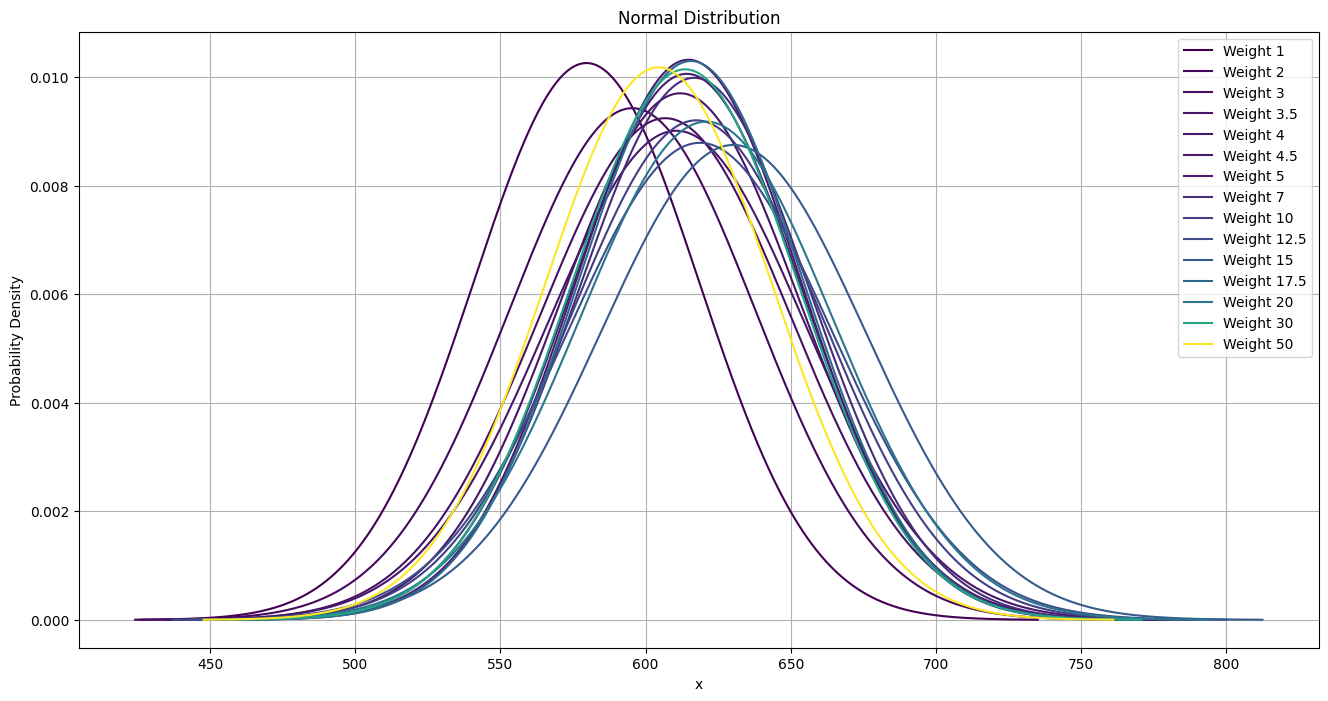

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.cm import get_cmap

# Get a colormap (e.g., 'viridis', 'plasma', 'cool', etc.)
cmap = get_cmap('viridis')

plt.figure(figsize=(16, 8))

# Normalize key values for colormap
keys_sorted = sorted(weight_scores.keys())
key_min, key_max = min(keys_sorted), max(keys_sorted)
normalized_keys = [(key - key_min) / (key_max - key_min) for key in keys_sorted]

for key, color_norm in zip(keys_sorted, normalized_keys):
    value = weight_scores[key]
    print(f'Weight {key}: mean = {np.mean(value)}, std = {np.std(value)}')
    
    # Define parameters for the normal distribution
    mean = np.mean(value)
    std_dev = np.std(value)

    # Generate data points
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)  # Values within ±4 standard deviations
    y = norm.pdf(x, mean, std_dev)  # Probability density function

    # Get color from colormap based on normalized key
    color = cmap(color_norm)

    # Plot the normal distribution
    plt.plot(x, y, color=color, label=f"Weight {key}")

# Final plot adjustments
plt.title("Normal Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

Weight 1: mean = 579.62, std = 38.871526854498526
Weight 2: mean = 595.42, std = 42.299924349814155
Weight 3: mean = 606.76, std = 43.14513182272132
Weight 3.5: mean = 611.92, std = 41.10466640176028
Weight 4: mean = 610.56, std = 44.25072202800763
Weight 4.5: mean = 614.76, std = 38.64120080949866
Weight 5: mean = 614.18, std = 39.6397225015514
Weight 7: mean = 616.76, std = 39.93272342327781
Weight 10: mean = 617.46, std = 43.32768629871667
Weight 12.5: mean = 618.72, std = 45.37137423530391
Weight 15: mean = 630.2, std = 45.57718727609242
Weight 17.5: mean = 615.62, std = 38.73029305337103
Weight 20: mean = 620.92, std = 43.44138119351179
Weight 30: mean = 613.58, std = 39.31518281783769
Weight 50: mean = 604.44, std = 39.17405263691772


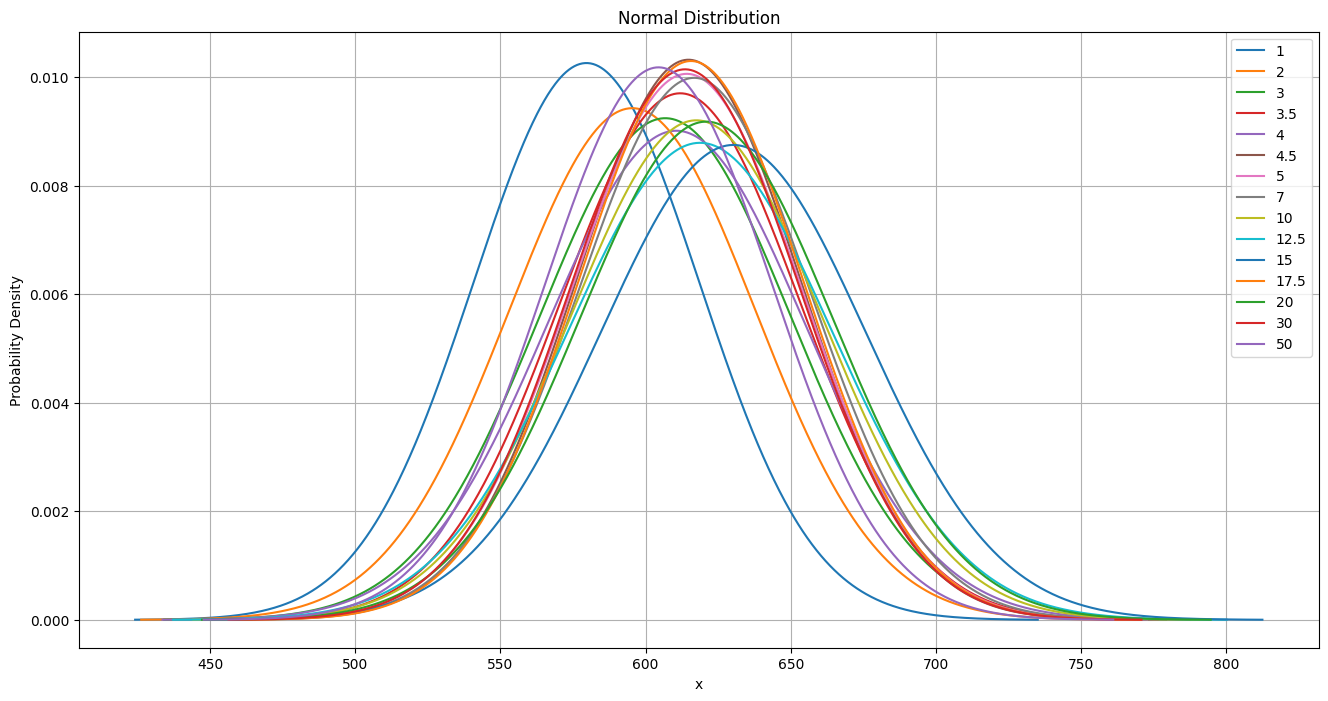

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.figure(figsize=(16,8))

for key in sorted(weight_scores.keys()):
    value = weight_scores[key]
    print(f'Weight {key}: mean = {np.mean(value)}, std = {np.std(value)}')
    
    # Define parameters for the normal distribution
    mean = np.mean(value)
    std_dev = np.std(value)

    # Generate data points
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)  # Values within ±4 standard deviations
    y = norm.pdf(x, mean, std_dev)  # Probability density function

    # Plot the normal distribution
    plt.plot(x, y, label=f"{key}")
    plt.title("Normal Distribution")
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)